In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score 
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
## Reading the data
df = pd.read_csv('customer_segmentation.csv', sep = '\t')

## Renaming columns
df.columns = ['customer_id','year_birth', 'education','marital_status','income', 'kid_home','teen_home','dt_customer','recency', 'mnt_wines', 'mnt_fruits','mnt_meat', 'mnt_fish','mtn_sweet','mnt_gold','num_deals_purchases','num_web_purchases','num_catalog_purchases','num_store_purchases','num_web_visits_month','accepted_cpm3','accepted_cpm4', 'accepted_cpm5', 'accepted_cpm1', 'accepted_cpm2', 'conplain','z_cost_contact', 'z_revenue', 'response']

## Basic info of the dataset
display(df.head(10))
display(df.shape)

,customer_id,year_birth,education,marital_status,income,kid_home,teen_home,dt_customer,recency,mnt_wines,...,num_web_visits_month,accepted_cpm3,accepted_cpm4,accepted_cpm5,accepted_cpm1,accepted_cpm2,conplain,z_cost_contact,z_revenue,response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,...,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,13-11-2012,34,235,...,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,08-05-2013,32,76,...,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,06-06-2013,19,14,...,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,13-03-2014,68,28,...,20,1,0,0,0,0,0,3,11,0


(2240, 29)

## Cleaning Data + Feature Engineering

In [3]:
## Fill null values with the mean
display(df.isnull().sum())

df = df.fillna(df['income'].mean())

assert (df.isnull().sum().sum() == 0)

customer_id               0
year_birth                0
education                 0
marital_status            0
income                   24
kid_home                  0
teen_home                 0
dt_customer               0
recency                   0
mnt_wines                 0
mnt_fruits                0
mnt_meat                  0
mnt_fish                  0
mtn_sweet                 0
mnt_gold                  0
num_deals_purchases       0
num_web_purchases         0
num_catalog_purchases     0
num_store_purchases       0
num_web_visits_month      0
accepted_cpm3             0
accepted_cpm4             0
accepted_cpm5             0
accepted_cpm1             0
accepted_cpm2             0
conplain                  0
z_cost_contact            0
z_revenue                 0
response                  0
dtype: int64

In [4]:
# Feature engineering: Creating new, useful features

# Create a feature with the total spent for the client
df['total_spent'] = df['mnt_wines']  + df['mnt_fruits'] + df['mnt_meat'] + df['mnt_fish'] + df['mtn_sweet'] + df['mnt_gold']

# Create a feature with the % of money spent on essential item (food-related) 
df['pct_essentials'] = (df['mnt_fruits'] + df['mnt_meat'] + df['mnt_fish'] + df['mtn_sweet'])/df['total_spent']

# Create a feature with the number of purchases for each client
df['num_purchases'] = df['num_web_purchases']+df['num_catalog_purchases'] + df['num_store_purchases']+df['num_web_visits_month']

# Create a feature with the number of children
df['num_children'] = df['kid_home'] + df['teen_home']

# Create a feature with the percentage of purchases made with a discount
df['pct_purchases_with_discount'] = df['num_deals_purchases'] / df['num_purchases']
df['pct_purchases_with_discount'].fillna(0, inplace=True)

# Create a feature with the age of the client, and another with the number of days since he's enrolled with the company
df['dt_customer'] = pd.to_datetime(df['dt_customer'])

df['days_since_enrollment'] = ((datetime(2015,1,1) - df['dt_customer']).dt.days)

df['age'] =  2015 - df['year_birth']

C:\Users\Fares Guerfala\AppData\Local\Temp\ipykernel_39852\451570582.py:20: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['dt_customer'] = pd.to_datetime(df['dt_customer'])


In [5]:
# Group some categories that have a similar meaning 
df['relationship'] = df['marital_status'].replace({'Married':1,'Together':1,
                            'Single':0, 'Divorced':0, 'Widow':0, 'Alone':0, 'Absurd':0,'YOLO':0})

df["education"] = df["education"].replace({'Basic':'Undergraduate', '2n Cycle':'Undergraduate', 
                                           'Graduation':'Graduated', 'Master':'Postgraduate', 'PhD':'Postgraduate'})

In [6]:
## Removing outliers
df = df[(df['age'] < 90) & (df['income'] < 200000)].reset_index(drop = True)

print("The new dataset have {} rows.".format(df.shape[0]))

The new dataset have 2236 rows.


In [7]:
## Since there are just 2 values with 0 purchases and both of them with a low total spent, we'll replace the 0's with 1's.
df.loc[(df['num_purchases'] == 0,'num_purchases')]=1

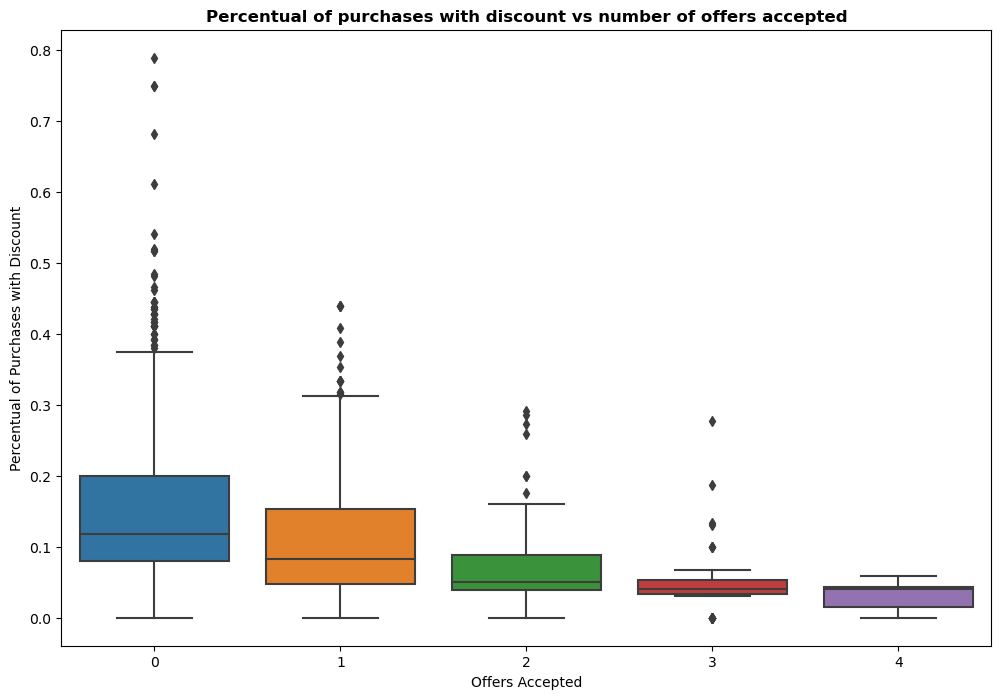

In [8]:
## Let's check the relationship between the "offers accepted", and the "percentual of purchases with discount"
df['accepted_sum'] = df['accepted_cpm3']+df['accepted_cpm4']+ df['accepted_cpm5'] + df['accepted_cpm1'] +df['accepted_cpm2']
plt.figure(figsize = (12,8))
plt.title('Percentual of purchases with discount vs number of offers accepted', fontweight = 'bold')
sns.boxplot(data = df, x = 'accepted_sum', y = 'pct_purchases_with_discount')
plt.xlabel('Offers Accepted')
plt.ylabel('Percentual of Purchases with Discount');

In [9]:
### Droping columns: Since we are going to use perform clusterization ahead, it's important that we only keep the 
### most important features, since we don't want the clusters to be created based on attributes that 
### are not that important to us



df = df.drop(['num_web_visits_month','recency', 'conplain', 'response', 'customer_id','dt_customer',
              'year_birth','kid_home','teen_home','mnt_wines', 'mnt_fruits','mnt_meat', 'mnt_fish', 
              'mtn_sweet', 'mnt_gold', 'num_web_purchases', 'num_catalog_purchases', 'num_store_purchases',
              'z_cost_contact','z_revenue', 'accepted_cpm3','accepted_cpm4', 'accepted_cpm5', 'accepted_cpm1',
              'accepted_cpm2', 'marital_status', 'accepted_sum'], axis = 1)

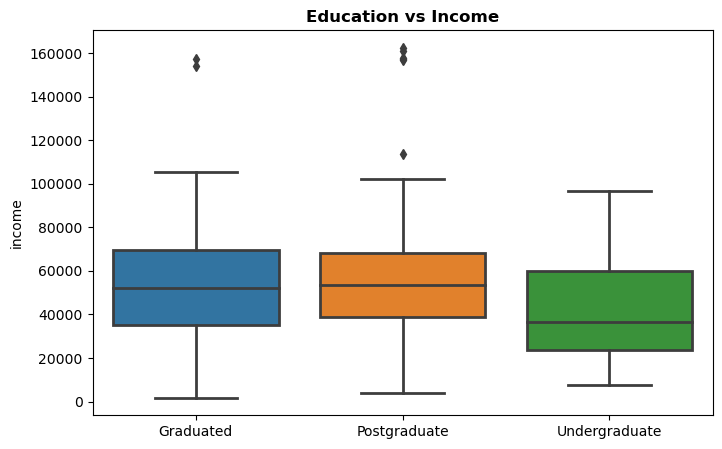

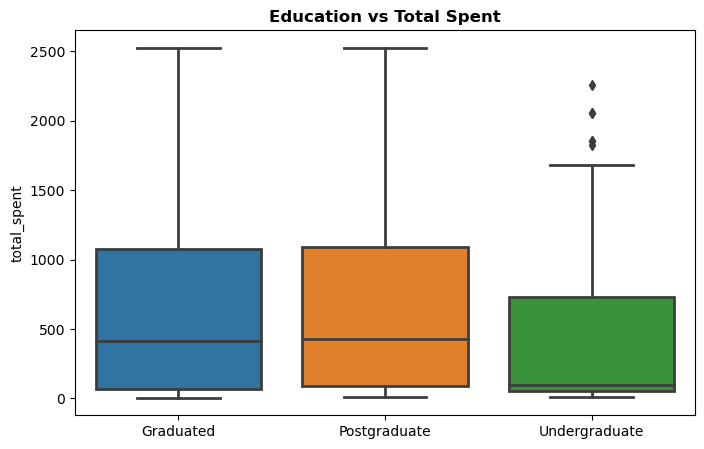

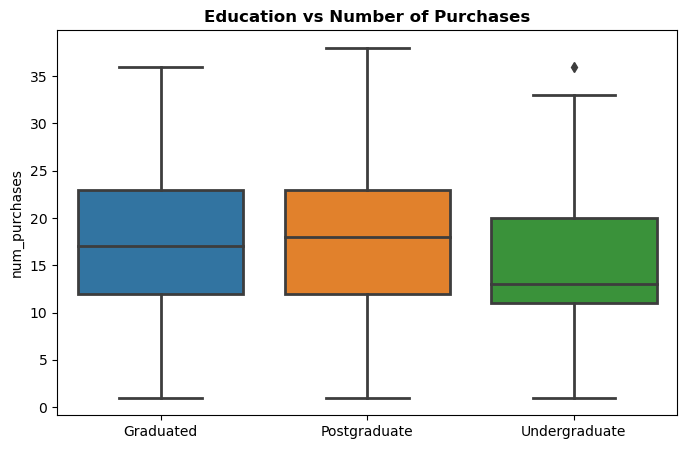

In [10]:
## Purchase behaviour vs Education
plt.figure(figsize = (8,5))
plt.title("Education vs Income", fontweight = 'bold', fontsize = 12)
sns.boxplot(y = df['income'] , x = df['education'], linewidth = 2)
plt.xlabel("")
plt.show()

plt.figure(figsize = (8,5))
plt.title("Education vs Total Spent", fontweight = 'bold', fontsize = 12)
sns.boxplot(y = df['total_spent'] , x = df['education'], linewidth = 2)
plt.xlabel("")
plt.show()

plt.figure(figsize = (8,5))
plt.title("Education vs Number of Purchases", fontweight = 'bold', fontsize = 12)
sns.boxplot(y = df['num_purchases'] , x = df['education'], linewidth = 2)
plt.xlabel("")
plt.show()


In [11]:
df["education"] = df["education"].replace({'Graduated':'Postgraduate'})
df['education'] = df['education'].replace({"Postgraduate": 1})
df['education'] = df['education'].replace({"Undergraduate": 0})
df.rename(columns={'education': 'high_education'}, inplace = True)

## Exploratory Data Analysis (EDA)

In [12]:
# Some descriptive statistics
df.describe()

,high_education,income,num_deals_purchases,total_spent,pct_essentials,num_purchases,num_children,pct_purchases_with_discount,days_since_enrollment,age,relationship
count,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000
mean,0.885957,51961.906544,2.326029,605.986583,0.421153,17.866279,0.950805,0.136283,538.179785,46.101968,0.644902
std,0.317935,21411.404811,1.933032,601.865156,0.194116,6.547265,0.752204,0.094970,232.311073,11.703281,0.478650
min,0.000000,1730.000000,0.000000,5.000000,0.027523,1.000000,0.000000,0.000000,26.000000,19.000000,0.000000
25%,1.000000,35502.500000,1.000000,69.000000,0.263047,12.000000,0.000000,0.066667,366.750000,38.000000,0.000000
50%,1.000000,51684.000000,2.000000,396.500000,0.428571,17.000000,1.000000,0.111111,539.000000,45.000000,1.000000
75%,1.000000,68275.750000,3.000000,1045.500000,0.570302,23.000000,1.000000,0.181818,712.000000,56.000000,1.000000
max,1.000000,162397.000000,15.000000,2525.000000,0.998844,38.000000,3.000000,0.789474,1089.000000,75.000000,1.000000


In [13]:
## We'll create an auxiliar column, to help us with the visualization. It will be deleted afterwards.
df['age_group'] = df['age']//10*10

cat_columns = ['high_education','num_children', 'relationship', 'age_group']
num_columns = ['income', 'num_deals_purchases','total_spent','num_purchases', 
       'pct_purchases_with_discount', 'days_since_enrollment', 'pct_essentials']

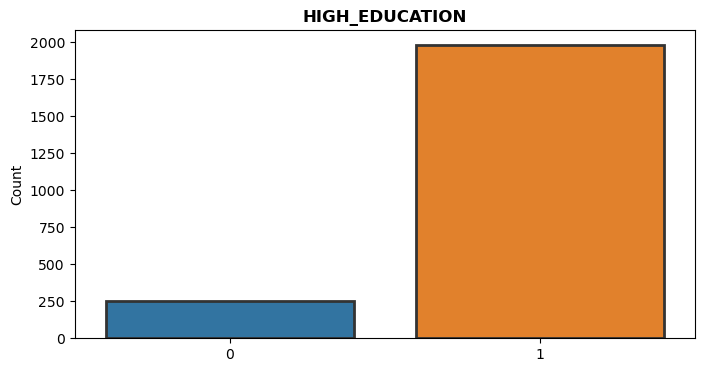

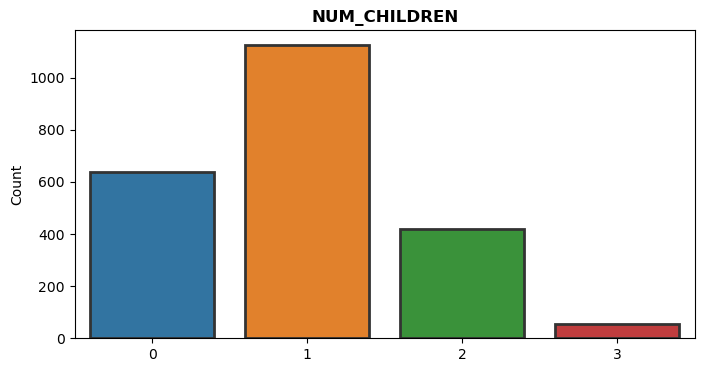

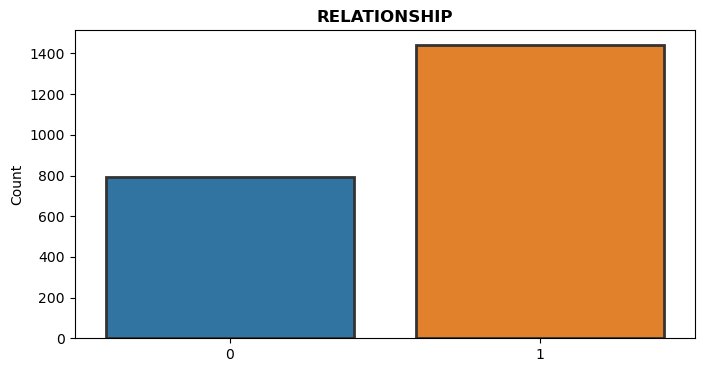

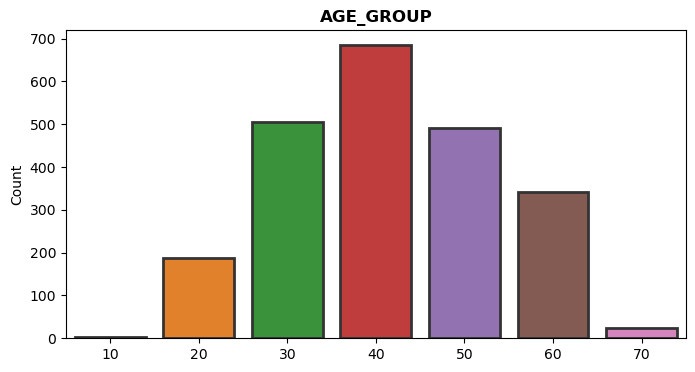

In [14]:
'''Categorical distributions (even though num_children and age_group are numerical variables,
for practical effects it makes a lot of sense to make their visualization as categorical)
'''

for cat in cat_columns:
    plt.figure(figsize = (8,4))
    plt.title(str.upper(cat), fontweight = 'bold')
    aux = df.groupby(cat).size().reset_index()#.rename({'pct_essentials':'count'}, axis = 1)
    ax = sns.barplot(x=cat, data=aux, y = 0, linewidth=2, edgecolor=".2").set(ylabel="Count", xlabel = None)
    
    plt.show()

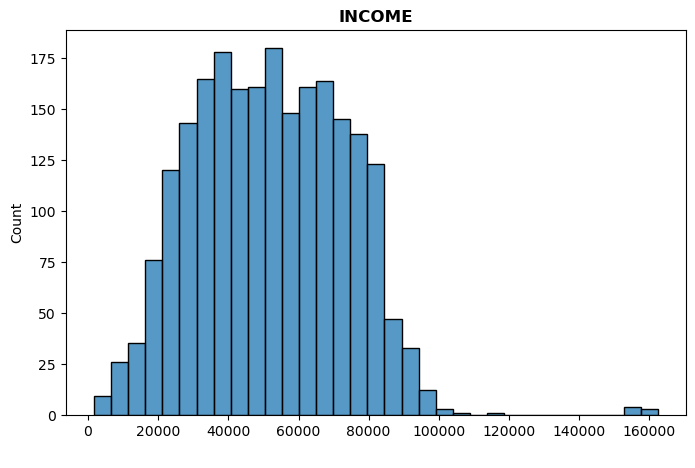

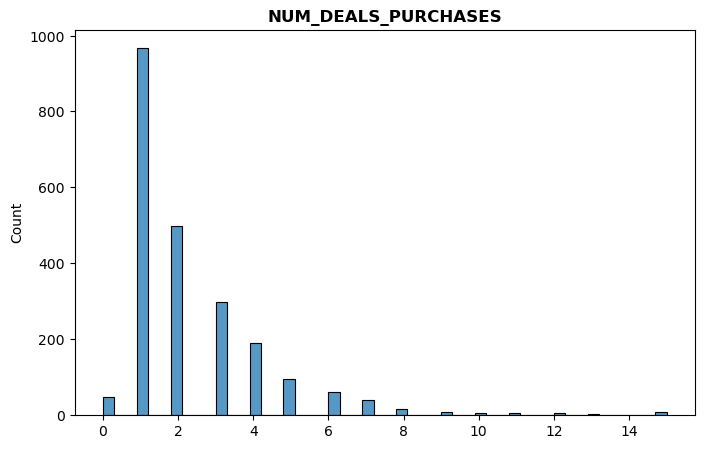

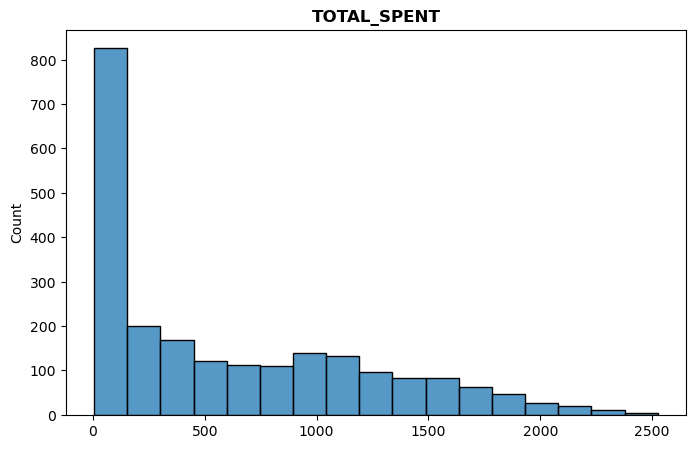

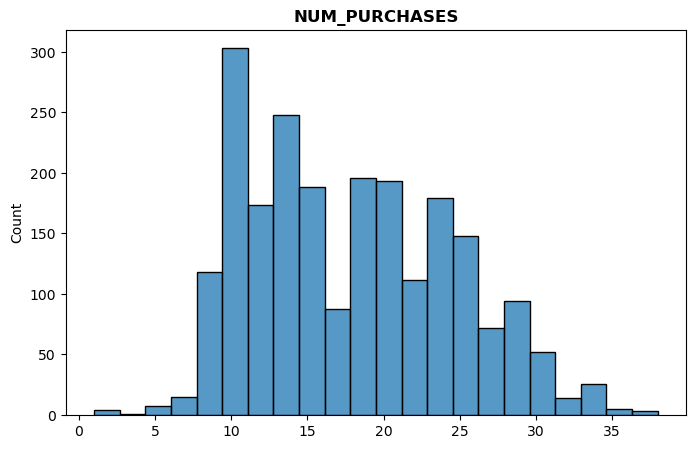

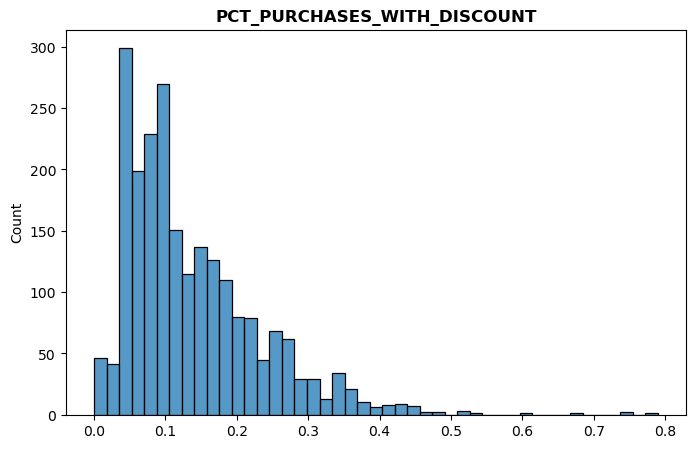

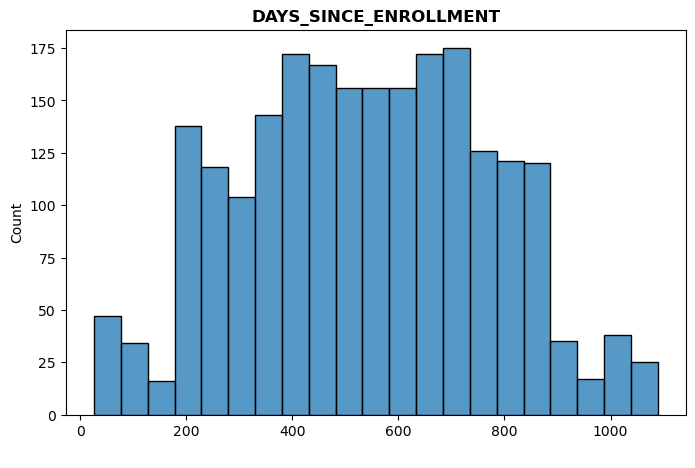

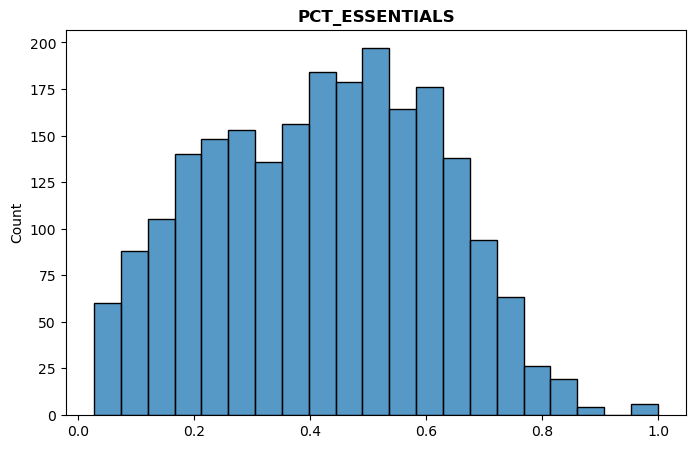

In [15]:
## Distribution of numerical variable

for num in num_columns:
    plt.figure(figsize = (8,5))
    plt.title(str.upper(num), fontweight = 'bold')
    ax = sns.histplot(x=num, data=df)
    ax.set_xlabel(" ")
    plt.show()

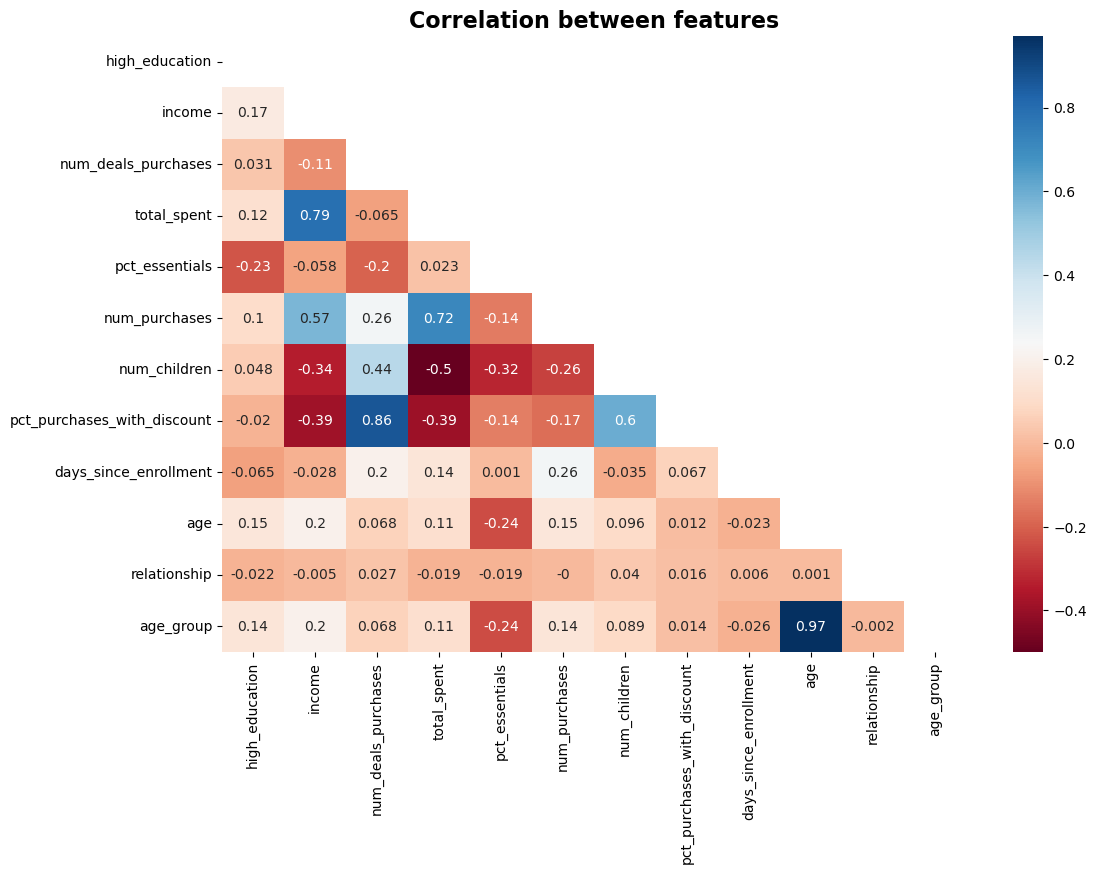

In [16]:
## Correlation Matrix
corr= df.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

fig = plt.figure(figsize=(12,8))
plt.title('Correlation between features', fontsize = 16, fontweight = 'bold')
sns.heatmap(round(df.corr(),3), annot=True, cmap="RdBu", mask = matrix);

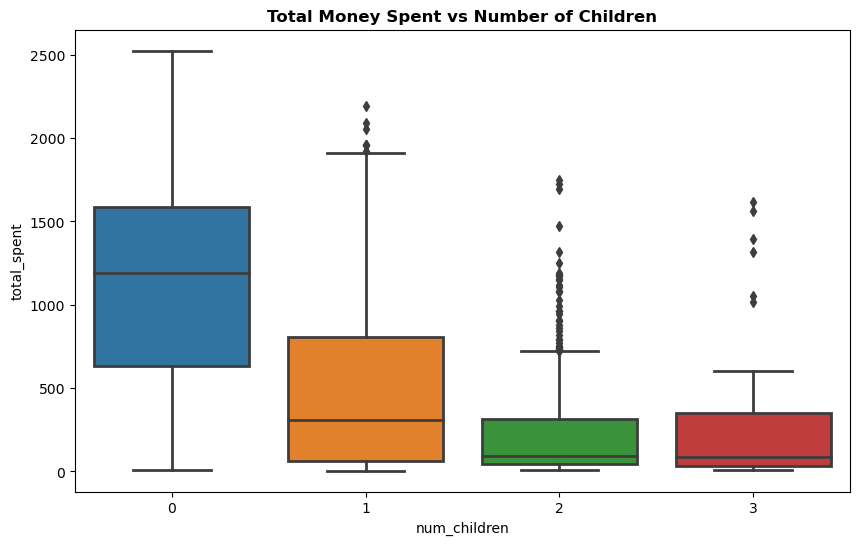

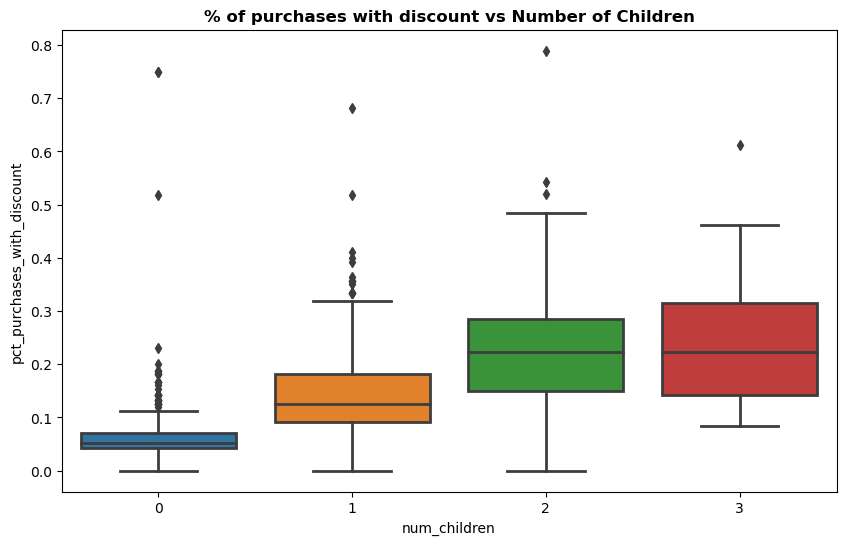

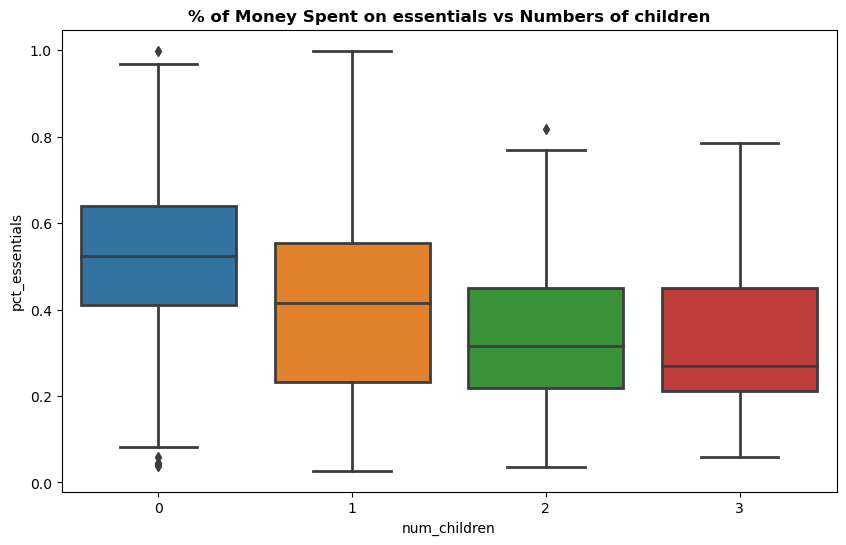

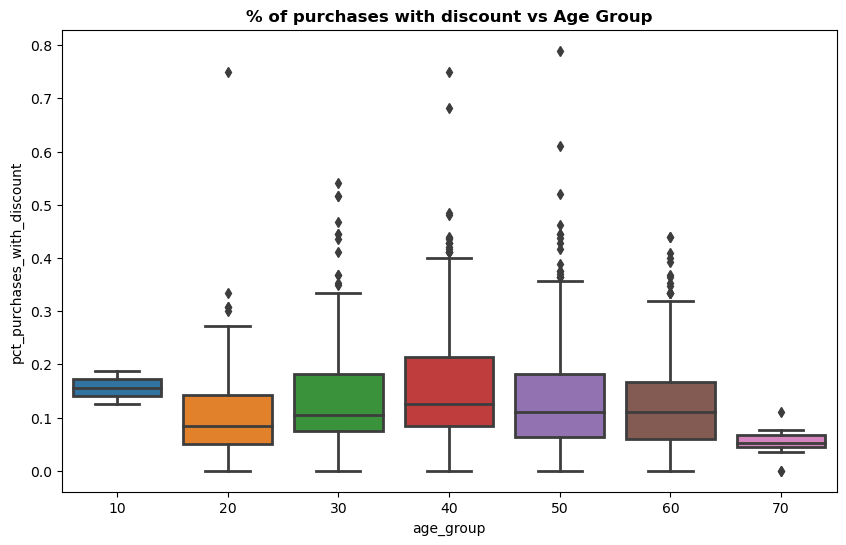

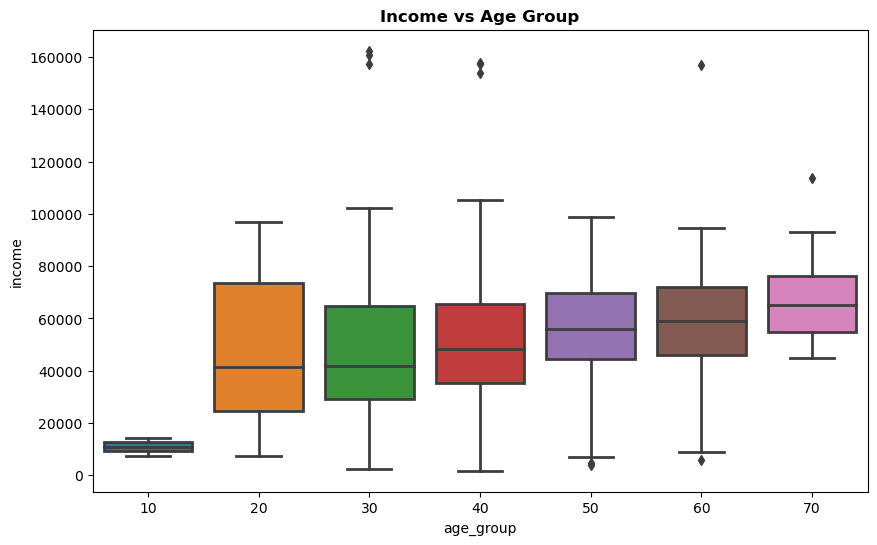

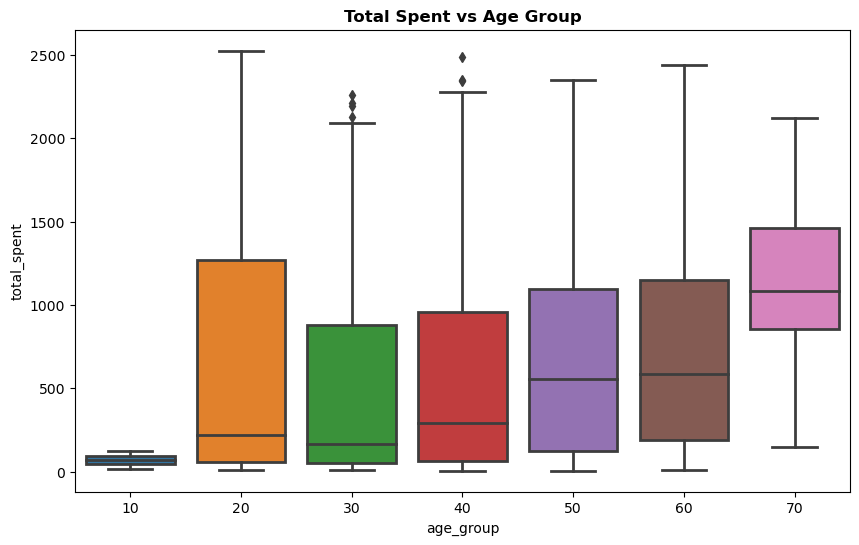

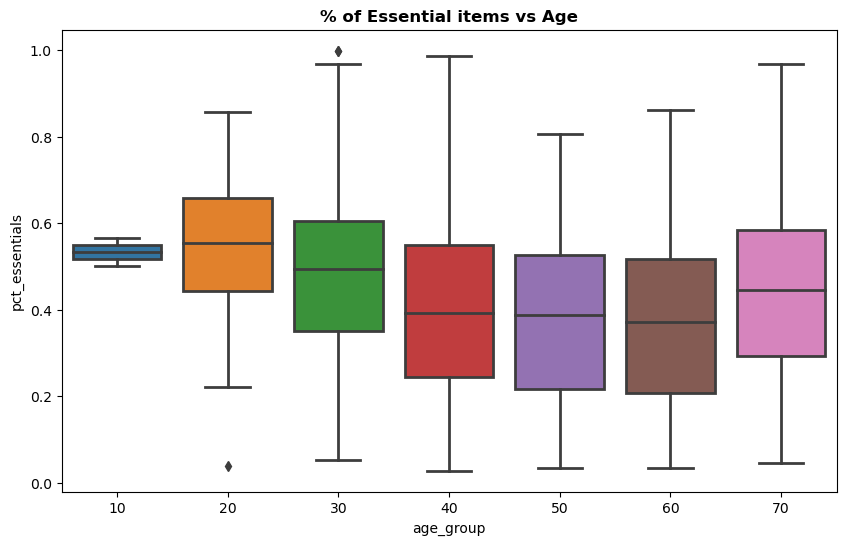

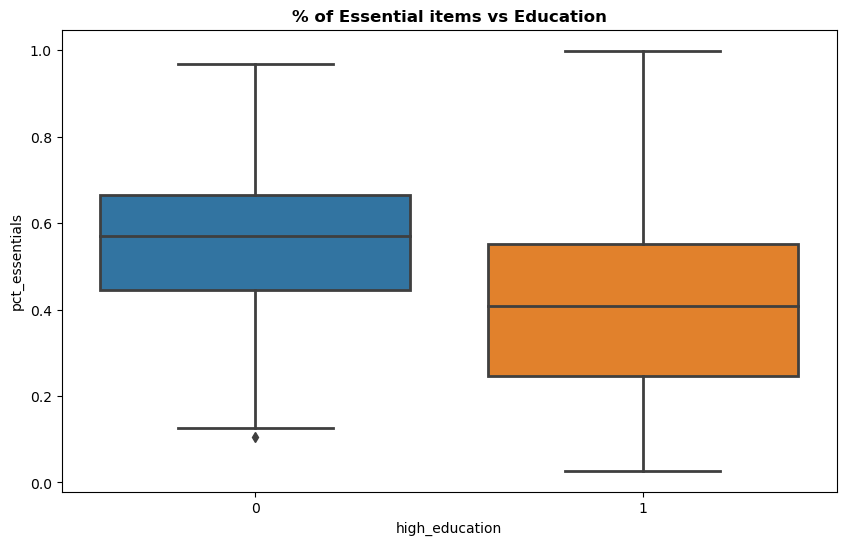

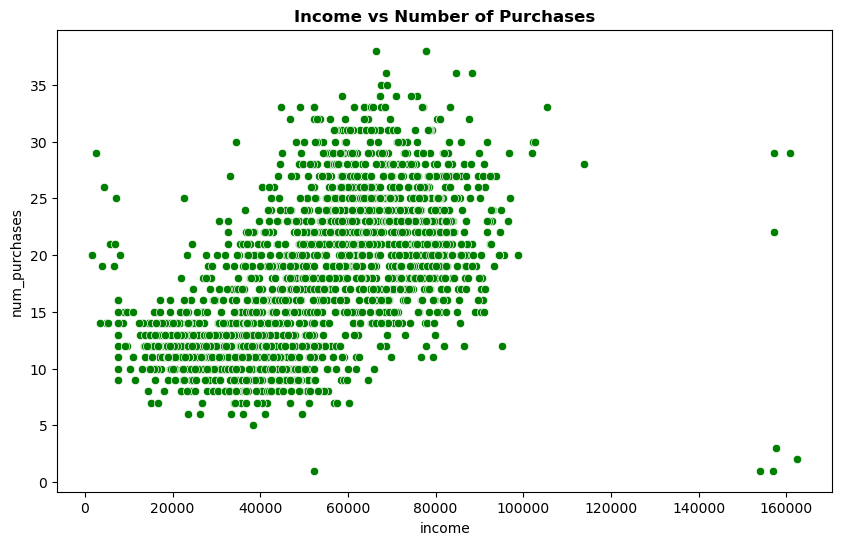

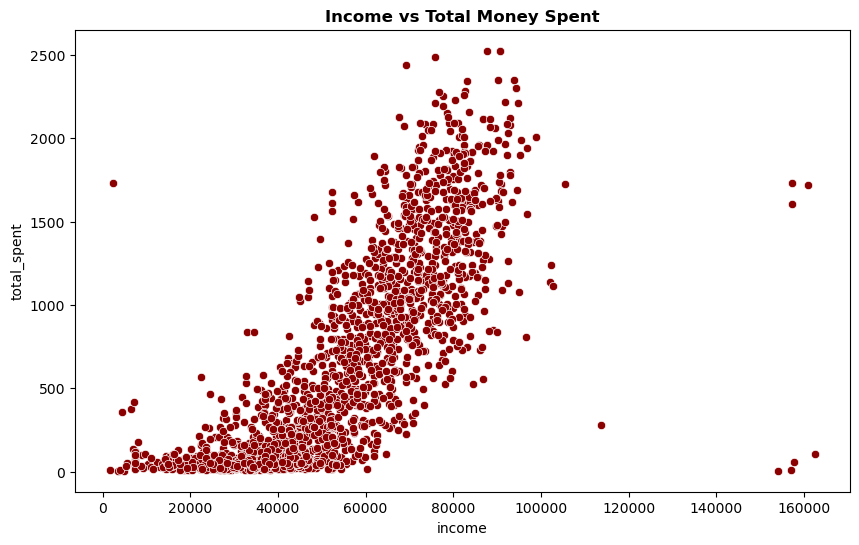

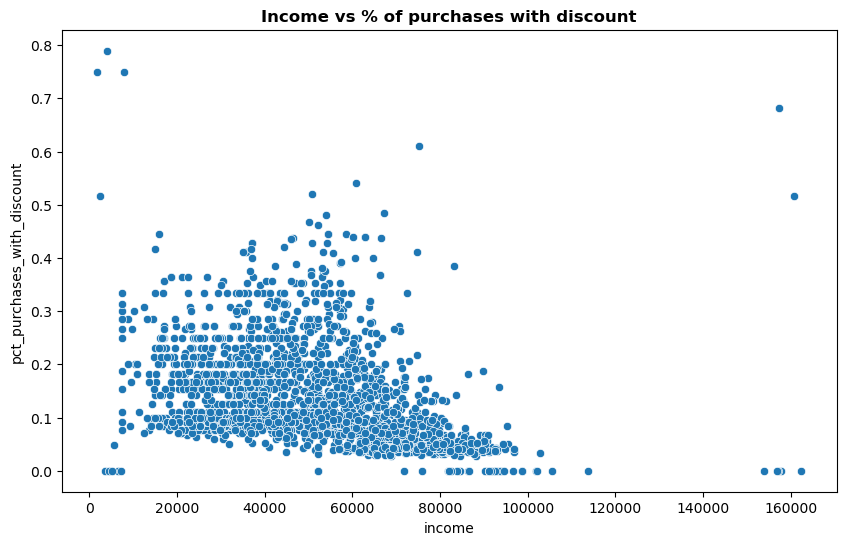

In [17]:
plt.figure(figsize = (10,6))
plt.title("Total Money Spent vs Number of Children", fontweight = 'bold')
sns.boxplot(data = df, y = 'total_spent', x = 'num_children', linewidth = 2)# interessante
plt.show()

plt.figure(figsize = (10,6))
plt.title("% of purchases with discount vs Number of Children", fontweight = 'bold')
sns.boxplot(data = df, y = 'pct_purchases_with_discount', x = 'num_children', linewidth = 2)
plt.show()

plt.figure(figsize = (10,6))
plt.title("% of Money Spent on essentials vs Numbers of children", fontweight = 'bold')
sns.boxplot(data = df, y = 'pct_essentials', x = 'num_children', linewidth = 2) ### esquisito
plt.show()


plt.figure(figsize = (10,6))
plt.title("% of purchases with discount vs Age Group", fontweight = 'bold')
sns.boxplot(data = df, y = 'pct_purchases_with_discount', x = 'age_group', linewidth = 2)
plt.show()

plt.figure(figsize = (10,6))
plt.title("Income vs Age Group", fontweight = 'bold')
sns.boxplot(data = df, y = 'income', x = 'age_group', linewidth = 2)
plt.show()


plt.figure(figsize = (10,6))
plt.title("Total Spent vs Age Group", fontweight = 'bold')
sns.boxplot(data = df, y = 'total_spent', x = 'age_group', linewidth = 2)
plt.show()

plt.figure(figsize = (10,6))
plt.title("% of Essential items vs Age", fontweight = 'bold')
sns.boxplot(data = df, y = 'pct_essentials', x = 'age_group', linewidth = 2)# interessante
plt.show()

plt.figure(figsize = (10,6))
plt.title("% of Essential items vs Education", fontweight = 'bold')
sns.boxplot(data = df, y = 'pct_essentials', x = 'high_education', linewidth = 2)# interessante
plt.show()

plt.figure(figsize = (10,6))
plt.title("Income vs Number of Purchases", fontweight = 'bold')
sns.scatterplot(data = df, x = 'income', y = 'num_purchases', color = 'green')
plt.show()

plt.figure(figsize = (10,6))
plt.title("Income vs Total Money Spent", fontweight = 'bold')
sns.scatterplot(data = df, x = 'income', y = 'total_spent', color = 'darkred')
plt.show()

plt.figure(figsize = (10,6))
plt.title("Income vs % of purchases with discount", fontweight = 'bold')
sns.scatterplot(data = df, x = 'income', y = 'pct_purchases_with_discount')
plt.show()


df = df.drop(['age_group', 'days_since_enrollment'], axis = 1)

## Clustering

### Standard Scaler


In [18]:
### Standardization
sc = StandardScaler()
df_scaled = pd.DataFrame(sc.fit_transform(df), columns = df.columns)
display(df_scaled[:5].T)

,0,1,2,3,4
high_education,0.358780,0.358780,0.358780,0.358780,0.358780
income,0.288513,-0.262438,0.917992,-1.182621,0.295754
num_deals_purchases,0.348738,-0.168700,-0.686137,-0.168700,1.383614
total_spent,1.680176,-0.962202,0.282541,-0.918994,-0.305762
pct_essentials,0.678727,-0.261669,-0.124932,1.427092,0.687108
num_purchases,1.700895,-1.354499,0.937047,-0.896190,0.173198
num_children,-1.264308,1.395139,-1.264308,0.065416,0.065416
pct_purchases_with_discount,-0.345812,0.905113,-0.996495,0.320003,1.336247
age,1.016868,1.273264,0.333146,-1.290693,-1.034298
relationship,-1.347635,-1.347635,0.742041,0.742041,0.742041


### Principal Components Analysis (PCA)


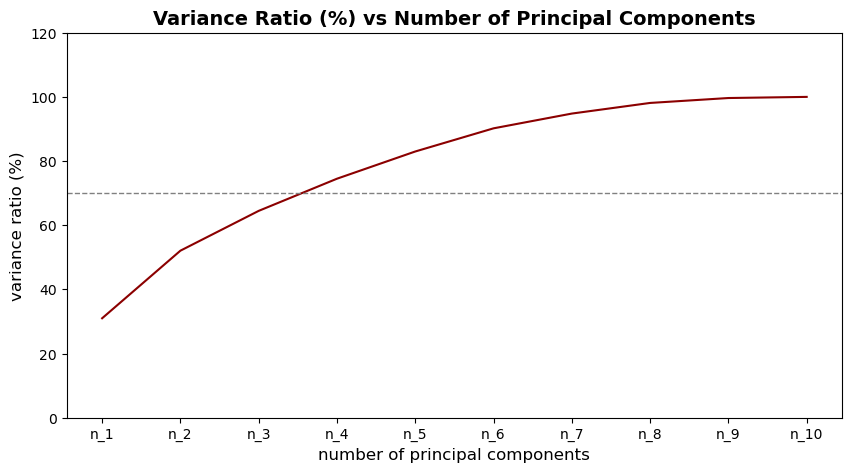

In [19]:
## Determining the number of principal components

variance_ratio = {}
for i in range(1, len(df_scaled.columns)+1):
    pca = PCA(n_components=i)
    pca.fit(df_scaled)
    variance_ratio[f'n_{i}'] = pca.explained_variance_ratio_.sum()*100
    
plt.figure(figsize = (10, 5))
plt.plot(variance_ratio.keys(), variance_ratio.values(), color = 'darkred')
plt.axhline(70, color = 'gray', ls = '--', lw = 1)
plt.title("Variance Ratio (%) vs Number of Principal Components", fontsize = 14, fontweight = 'bold')
plt.ylabel("variance ratio (%)", fontsize = 12)
plt.xlabel("number of principal components", fontsize = 12)
plt.ylim([0, 120])
plt.show()

In [20]:
## Applying PCA to create a new dataset with 4 Princpal Components.

pca = PCA(n_components = 4, random_state = 123)
pca.fit(df_scaled)
df_pca = pd.DataFrame(pca.transform(df_scaled),
                      columns = (["PC1", "PC2", "PC3", "PC4"]))
df_pca.head(5)

,PC1,PC2,PC3,PC4
0,-2.274351,1.038793,0.657425,1.394765
1,1.873943,0.221423,-1.444409,1.300393
2,-2.032854,-0.038882,-0.403002,-0.784897
3,1.362291,-1.679339,0.632087,-0.542764
4,0.935971,0.760547,1.514053,-0.494132


### K-Means

C:\Users\Fares Guerfala\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Fares Guerfala\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Fares Guerfala\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Fares Guerfala\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

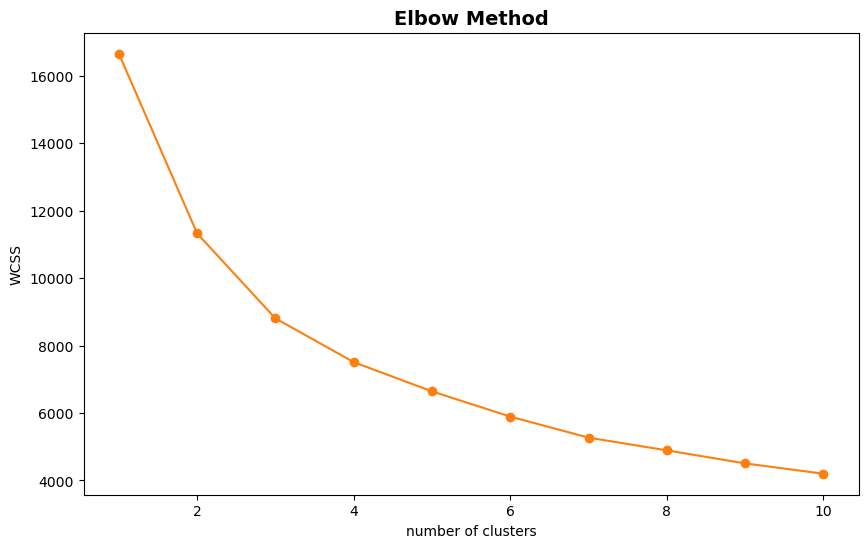

In [21]:
## Determining the ideal number of clusters: Elbow method
wcss=[]
for i in range (1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',random_state=123)
    kmeans.fit(df_pca)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(range(1,11), wcss, marker='o', color = 'tab:orange')
plt.title('Elbow Method', fontsize = 14, fontweight = 'bold')
plt.xlabel('number of clusters')
plt.ylabel('WCSS')
plt.show()

C:\Users\Fares Guerfala\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Fares Guerfala\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Fares Guerfala\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Fares Guerfala\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

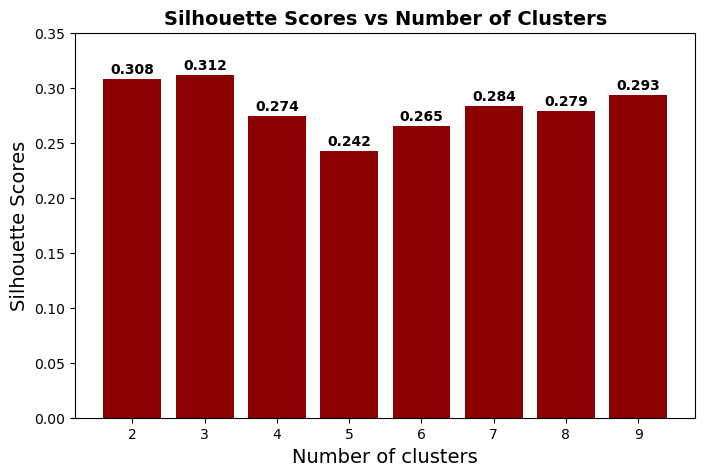

In [24]:
silhouette_scores = []

for i in range(2,10):
    m1 = KMeans(n_clusters=i, random_state=123)
    c = m1.fit_predict(df_pca)
    silhouette_scores.append(silhouette_score(df_pca, m1.fit_predict(df_pca)))

plt.figure(figsize = (8,5))
plt.bar(range(2,10), silhouette_scores, color = 'darkred')
plt.title("Silhouette Scores vs Number of Clusters", fontsize = 14, fontweight = 'bold')
plt.xlabel('Number of clusters', fontsize = 14) 
plt.ylabel('Silhouette Scores', fontsize = 14)
plt.ylim(0,0.35)
for a, b in enumerate(silhouette_scores):
    plt.text(a + 1.7, b + 0.005, str(round(b,3)), color='black', fontweight='bold')
plt.show()

In [23]:
kmeans = KMeans(n_clusters=3, random_state=123).fit(df_pca)
pred = kmeans.predict(df_pca)
df['cluster'] = pred + 1
df.head()

C:\Users\Fares Guerfala\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,high_education,income,num_deals_purchases,total_spent,pct_essentials,num_purchases,num_children,pct_purchases_with_discount,age,relationship,cluster
0,1,58138.0,3,1617,0.552876,29,0,0.103448,58,0,2
1,1,46344.0,2,27,0.370370,9,2,0.222222,61,0,3
2,1,71613.0,1,776,0.396907,24,0,0.041667,50,1,2
3,1,26646.0,2,53,0.698113,12,1,0.166667,31,1,3
4,1,58293.0,5,422,0.554502,19,1,0.263158,34,1,1


### Analyzing the clusters

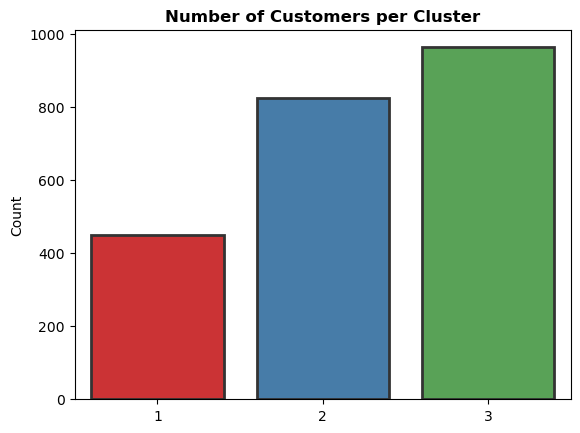

In [25]:
aux = df.cluster.value_counts()/len(df.count())
plt.title('Number of Customers per Cluster', fontweight = 'bold')
aux = df.groupby('cluster').size().reset_index()#.rename({'pct_essentials':'count'}, axis = 1)
ax = sns.barplot(x='cluster', data=aux, y = 0, linewidth=2, edgecolor=".2",  palette = 'Set1').set(ylabel="Count", xlabel = None)

In [26]:
# Creating an auxiliar dataset to help the evaluation
clusters_evaluation = df.groupby('cluster').mean().T
clusters_evaluation['mean_dataset'] = df.mean().T
clusters_evaluation

cluster,1,2,3,mean_dataset
high_education,0.933185,0.928398,0.827622,0.885957
income,50795.914832,72414.880166,35004.772603,51961.906544
num_deals_purchases,5.227171,1.463592,1.711319,2.326029
total_spent,537.712695,1224.203883,108.835929,605.986583
pct_essentials,0.304695,0.445068,0.454990,0.421153
num_purchases,20.516704,22.891990,12.330218,17.866279
num_children,1.567929,0.402913,1.131880,0.950805
pct_purchases_with_discount,0.261420,0.064077,0.139721,0.136283
age,49.783964,47.888350,42.856698,46.101968
relationship,0.677060,0.620146,0.651090,0.644902


In [27]:
plt.figure(figsize = (8,8))
clusters_evaluation.drop('mean_dataset', axis = 1).style.background_gradient(cmap='RdYlGn',axis=1)

cluster,1,2,3
high_education,0.933185,0.928398,0.827622
income,50795.914832,72414.880166,35004.772603
num_deals_purchases,5.227171,1.463592,1.711319
total_spent,537.712695,1224.203883,108.835929
pct_essentials,0.304695,0.445068,0.454990
num_purchases,20.516704,22.891990,12.330218
num_children,1.567929,0.402913,1.131880
pct_purchases_with_discount,0.261420,0.064077,0.139721
age,49.783964,47.888350,42.856698
relationship,0.677060,0.620146,0.651090


<Figure size 800x800 with 0 Axes>

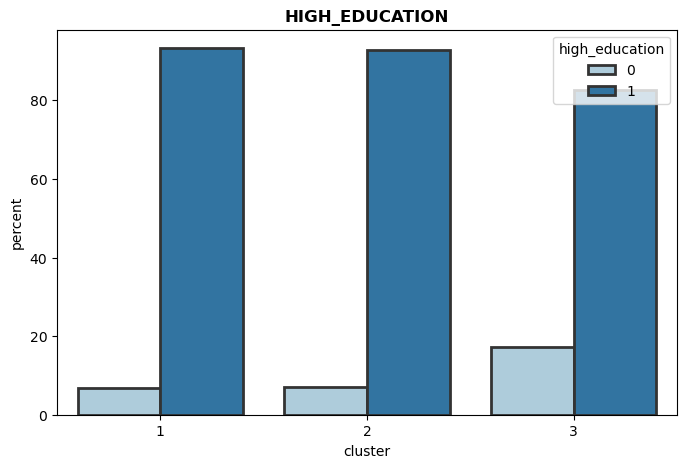

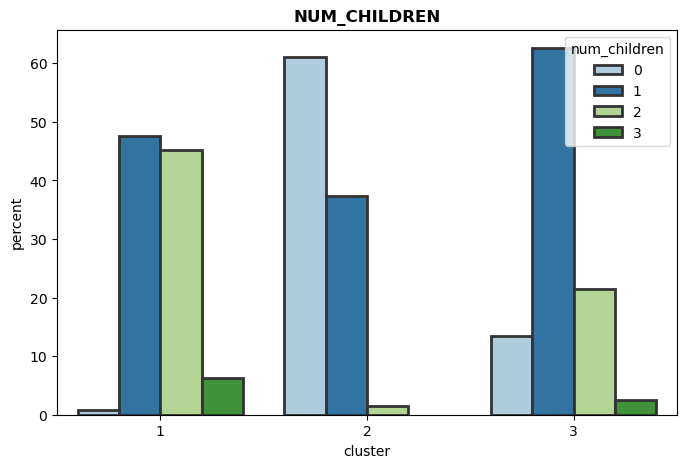

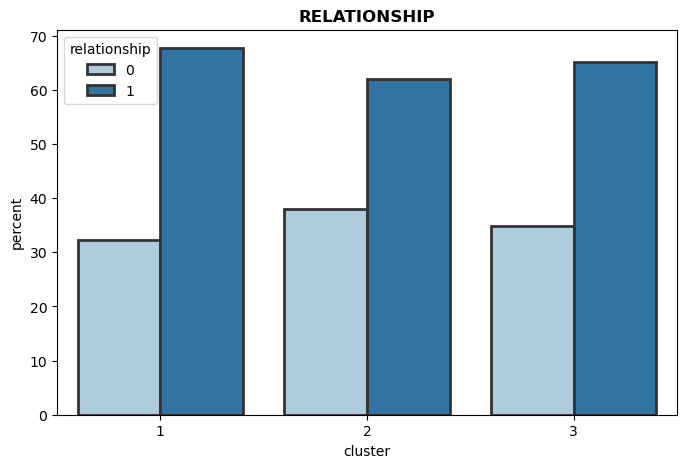

In [28]:
## Categorical Visualizations

cat_columns = ['high_education','num_children', 'relationship']
num_columns = ['income','total_spent','num_purchases', 
       'pct_purchases_with_discount', 'age', 'pct_essentials']

for cat in cat_columns:
    plt.figure(figsize = (8,5))
    plt.title(str.upper(cat), fontweight = 'bold')
    df_aux = df.groupby('cluster')[cat].value_counts(normalize=True).mul(100).rename('percent').reset_index()
    sns.barplot(data = df_aux, x='cluster',y='percent',hue=cat, palette = 'Paired',linewidth=2, edgecolor=".2");
    plt.show()    


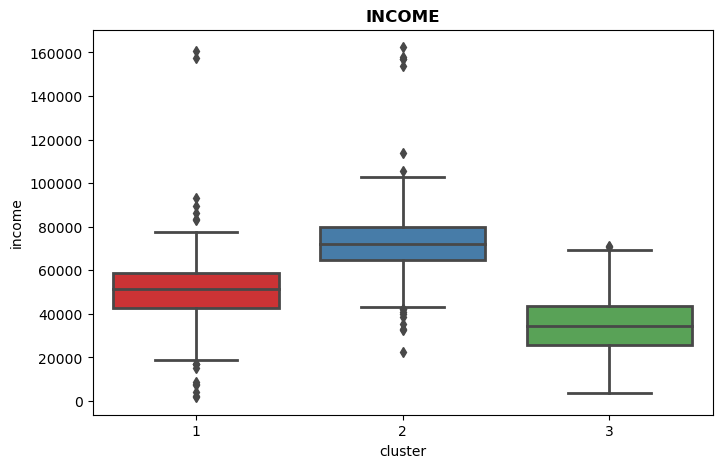

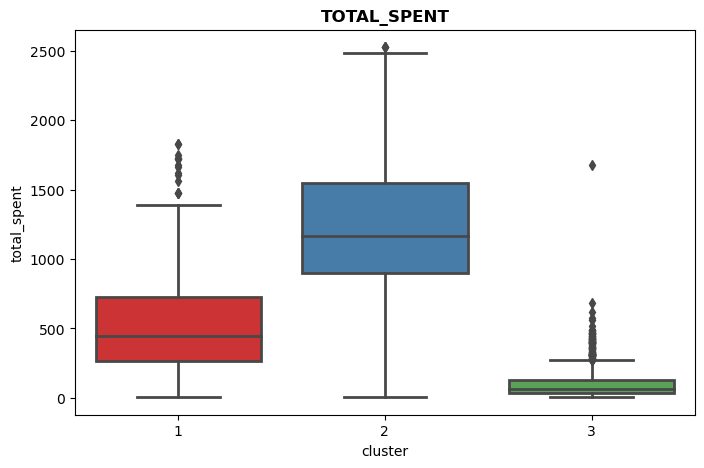

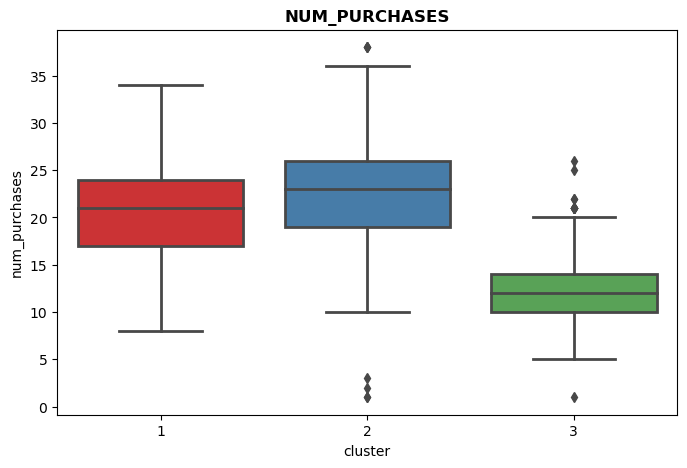

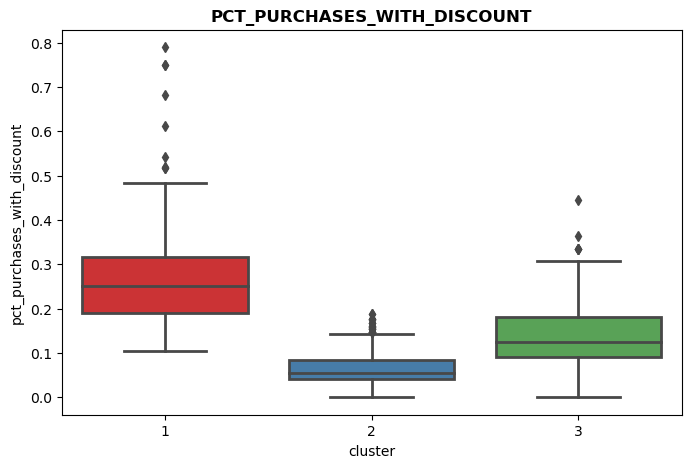

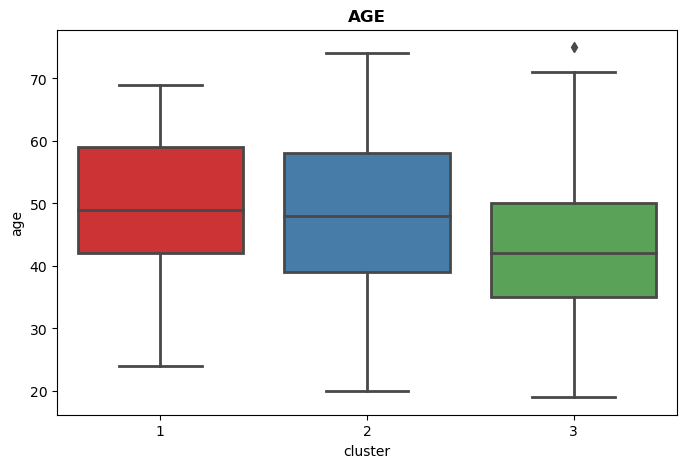

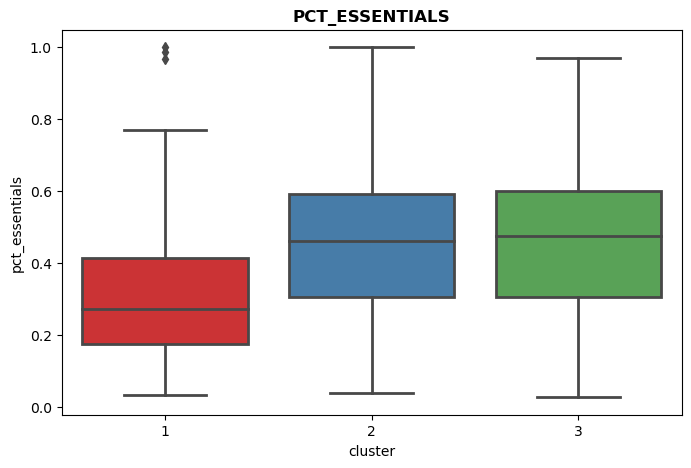

In [29]:
## Numerical Variables

for num in num_columns:
    plt.figure(figsize = (8,5))
    plt.title(str.upper(num), fontweight = 'bold')
    ax = sns.boxplot(y=num, x = 'cluster', data=df, palette = 'Set1', linewidth = 2)#.set(ylabel="Count", xlabel = None)
    plt.show()


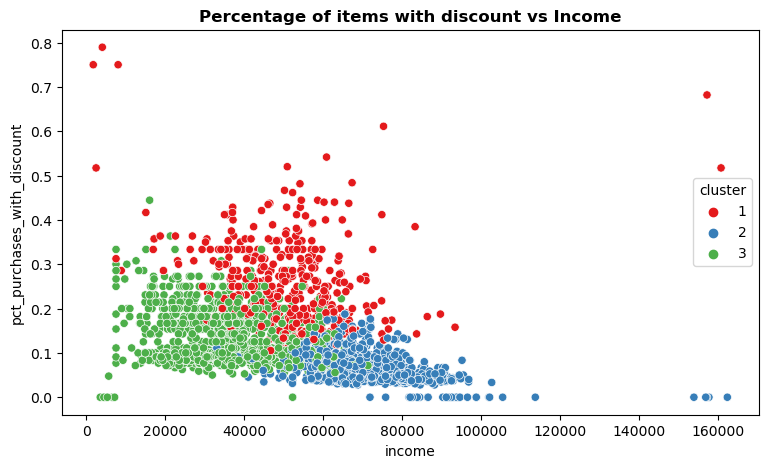

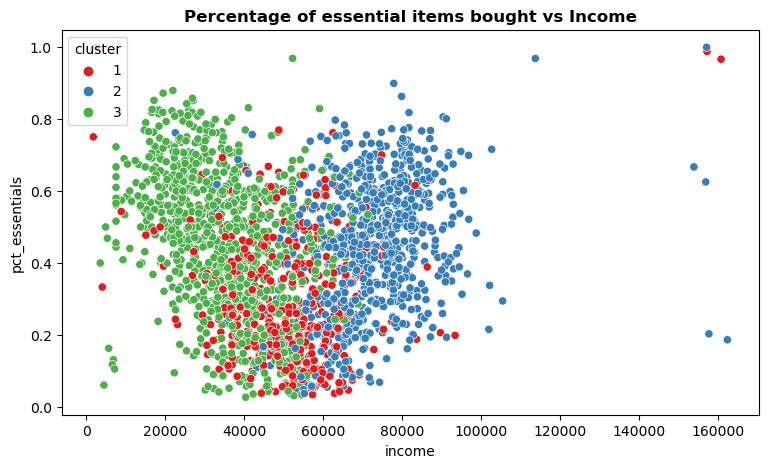

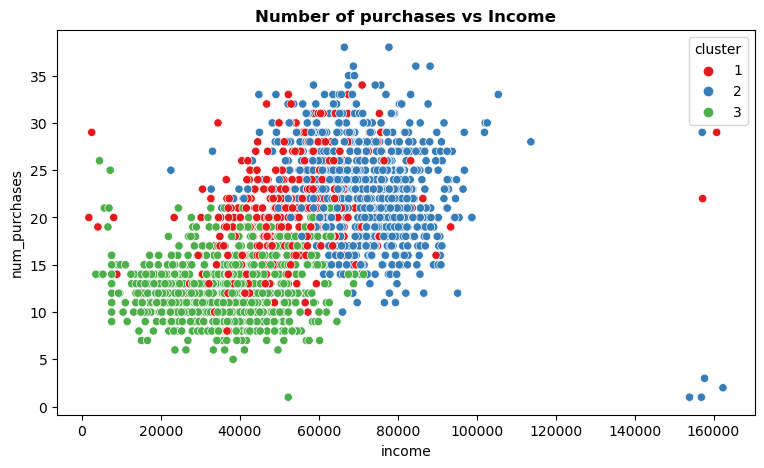

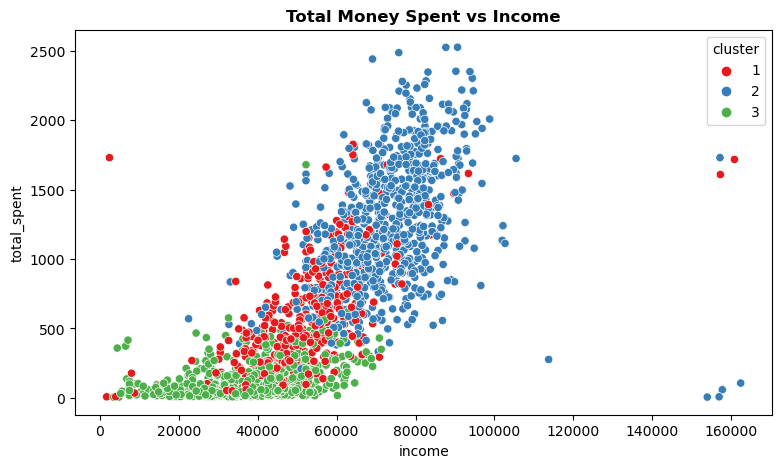

In [30]:
plt.figure(figsize = (9,5))
plt.title('Percentage of items with discount vs Income', fontweight = 'bold')
sns.scatterplot(data = df, x = 'income', y = 'pct_purchases_with_discount', hue = 'cluster', palette = 'Set1')
plt.show()

plt.figure(figsize = (9,5))
plt.title('Percentage of essential items bought vs Income', fontweight = 'bold')
sns.scatterplot(data = df, x = 'income', y = 'pct_essentials', hue = 'cluster', palette = 'Set1')
plt.show()

plt.figure(figsize = (9,5))
plt.title('Number of purchases vs Income', fontweight = 'bold')
sns.scatterplot(data = df, x = 'income', y = 'num_purchases', hue = 'cluster', palette = 'Set1')
plt.show()

plt.figure(figsize = (9,5))
plt.title('Total Money Spent vs Income', fontweight = 'bold')
sns.scatterplot(data = df, x = 'income', y = 'total_spent', hue = 'cluster', palette = 'Set1')
plt.show()